This notebook shows pre-processing part of OCR recognition

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import argparse
from PIL import Image
from PIL import ImageFilter
from pylab import *

First step is to insert image

In [2]:
img = Image.open('./textArea01.png')

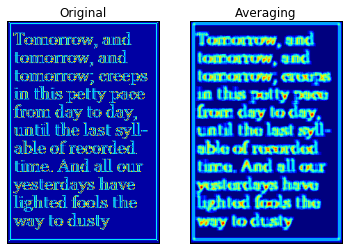

In [3]:
img=np.asarray(img)
#create kernel
kernel = np.ones((5,5),np.float32)/25
dst = cv2.filter2D(img,-1,kernel)

plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(dst),plt.title('Averaging')
plt.xticks([]), plt.yticks([])
plt.show()

In [4]:
kernel1 = np.array([[-1,-1,-1],[2, 2, 2],[-1, -1, -1]])
kernel2 = np.array([[-1, 2,-1],[-1, 2, -1],[-1, 2, -1]])
kernel3 = np.array([[2,-1,-1],[-1, 2, -1],[-1, -1, 2]])
kernel4 = np.array([[-1,-1,2],[-1, 2, -1],[2, -1, -1]])

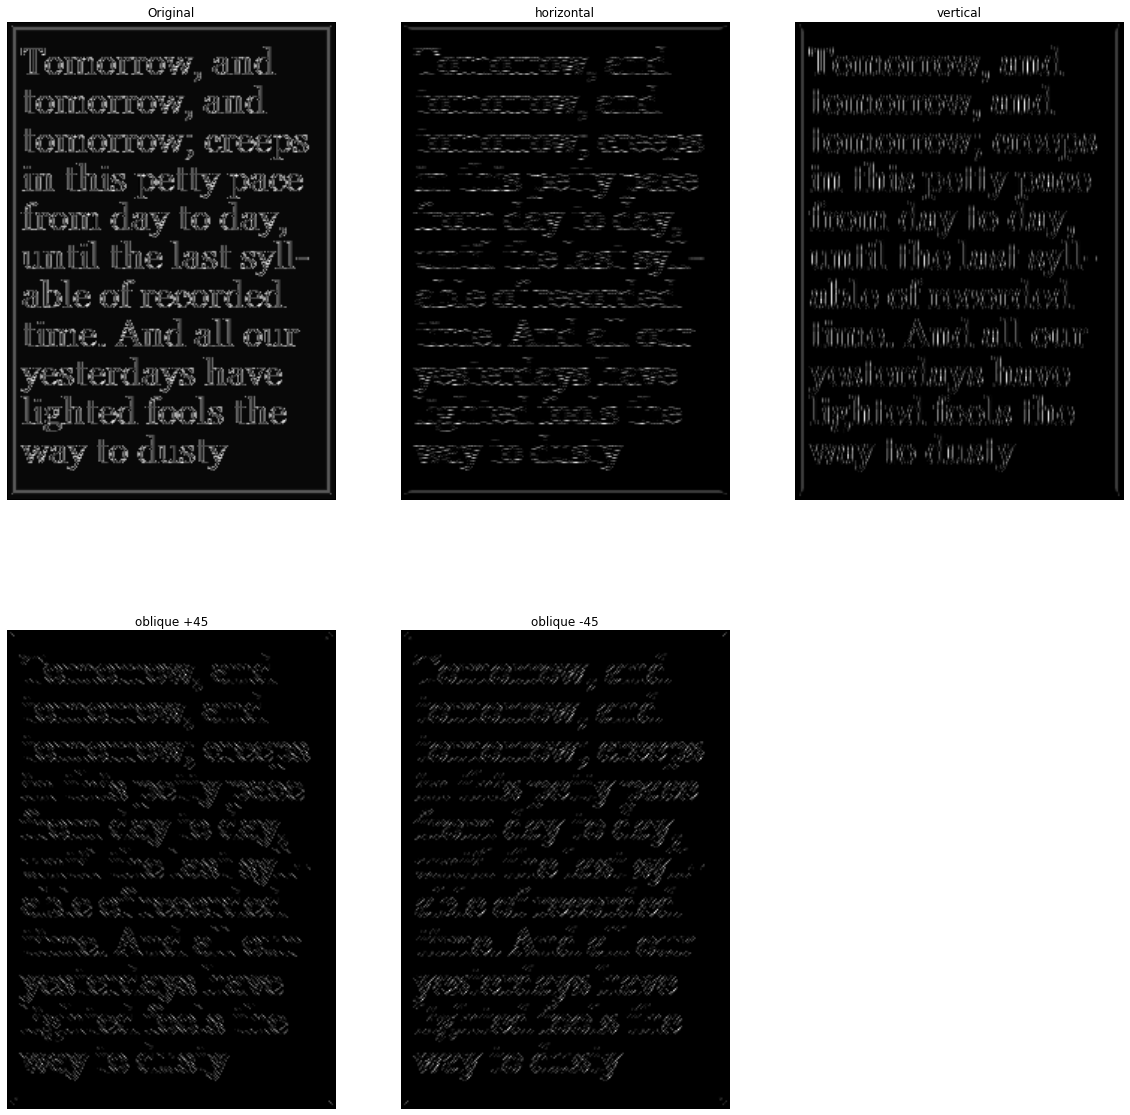

In [5]:
pl = subplots(figsize=(20, 20))
plt.subplot(231),plt.imshow(img, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(232),plt.imshow(cv2.filter2D(img,-1,kernel1), cmap='gray'),plt.title('horizontal')
plt.xticks([]), plt.yticks([])
plt.subplot(233),plt.imshow(cv2.filter2D(img,-1,kernel2), cmap='gray'),plt.title('vertical')
plt.xticks([]), plt.yticks([])
plt.subplot(234),plt.imshow(cv2.filter2D(img,-1,kernel3), cmap='gray'),plt.title('oblique +45')
plt.xticks([]), plt.yticks([])
plt.subplot(235),plt.imshow(cv2.filter2D(img,-1,kernel4), cmap='gray'),plt.title('oblique -45')
plt.xticks([]), plt.yticks([])
plt.show()

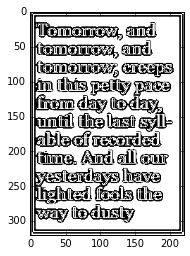

In [6]:
#http://stackoverflow.com/questions/34981144/split-text-lines-in-scanned-document
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
plt.imshow(th3,'gray')
plt.show()

In [7]:
pixelpointsCV2 = cv2.findNonZero(th3)

In [8]:
rect = cv2.minAreaRect(pixelpointsCV2);
print rect
box = cv2.boxPoints(rect)
if (rect[1][0] > rect[1][1]):
    rect[1][0],rect[1][1] = rect[1][1],rect[1][0]
    rect[1] += 90
box = np.int0(box)
print box

((109.49998474121094, 159.49996948242188), (218.99996948242188, 318.99993896484375), 0.0)
[[  0 318]
 [  0   0]
 [218   0]
 [218 318]]


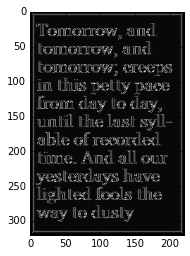

In [9]:
plt.imshow(cv2.drawContours(img,[box],0,(0,0,255),2),'gray')
plt.show()

In [10]:
centerx,centery = ( np.average(box[:2]),np.average(box[2:]))
print centerx,centery,rect[2]
M = cv2.getRotationMatrix2D((centerx,centery), rect[2], 1.0);

79.5 188.5 0.0


In [11]:
rotated = cv2.warpAffine(th3,M.T.T,(th3.shape[1],th3.shape[0]))

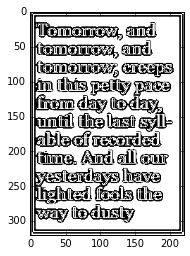

In [12]:
plt.imshow(rotated,'gray')
plt.show()

In [13]:
horProj= cv2.reduce(rotated,1,3)
th = 0
hist = horProj <= th
horProj=np.sum(rotated,1)
print horProj

[56100 56100  2040  2040 55080 55080  2040  2040 53550 54060 54060 54060
 54060 54060 54060 54060 48450 49215 52275 49980 50235 49470 27540 15810
 38760 32895 33915 28815 30600 31875 32385 29835 28305 29325 31365 41820
 17595 27030 52785 53295 53040 53295 52530 53805 53295 51765 52530 51765
 29325 17595 41310 33150 34425 29580 31365 32640 33150 30600 29070 30090
 31875 41055 17595 28050 52785 53295 53040 53295 54060 54060 54060 53040
 53550 52785 25245  8160 38250 30090 29070 23460 27540 31365 27030 23460
 21675 26520 28305 35190 11220 22695 50745 51255 52530 50490 50490 53550
 51510 48195 49980 45390 29070 14535 38505 30090 27795 26265 27540 31620
 28050 25500 25245 28815 30855 38760 14535 27285 48960 50235 51510 46410
 46665 51765 51255 48960 49215 47685 29835 18105 40800 31110 31620 27540
 27285 29835 30855 29325 27540 29325 31620 40545 17340 25500 49725 50235
 49215 46665 45135 52020 48960 44115 45645 42075 30090 19125 39525 30345
 26775 26265 27795 30090 26265 24480 27540 27540 30

In [15]:
ycoords = []
y=0
count=0
isSpace = False
for i in range(rotated.shape[0]):
    if not isSpace:
        if(hist[i]):
            isSpace=True
            count=1
            y=i
    else:
        if(hist[i]):
            isSpace=False
            ycoords.append(y/count)
        else:
            count+=1
            y+=i
            

In [16]:
print len(ycoords)
result = rotated
plt.imshow(rotated,'gray')
X = np.linspace(0,rotated.shape[1]-1,rotated.shape[1])
for i in range(len(ycoords)):
    theList = [ycoords[i] for l in range(len(X))]
    plt.plot(X,theList,'red')

158


In [19]:
plt.show()

In [30]:
#http://www.pyimagesearch.com/2017/02/20/text-skew-correction-opencv-python/
#image = cv2.imread("C:\Users\Franjo\Documents\FER\DOAS\Projekt\skew2.png")
image = cv2.imread("C:\Users\Franjo\Documents\FER\DOAS\DOAS - Projekt\cover.png")

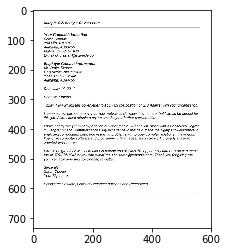

In [31]:
plt.imshow(image,"gray")
plt.show()

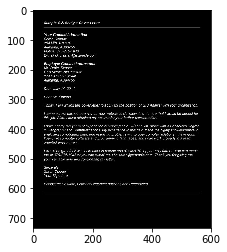

In [32]:
# convert the image to grayscale and flip the foreground
# and background to ensure foreground is now "white" and
# the background is "black"
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.bitwise_not(gray)
 
# threshold the image, setting all foreground pixels to
# 255 and all background pixels to 0
thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(gray,'gray')
plt.show()

In [33]:
# grab the (x, y) coordinates of all pixel values that
# are greater than zero, then use these coordinates to
# compute a rotated bounding box that contains all
# coordinates
coords = np.column_stack(np.where(thresh > 0))
angle = cv2.minAreaRect(coords)[-1]
 
# the `cv2.minAreaRect` function returns values in the
# range [-90, 0); as the rectangle rotates clockwise the
# returned angle trends to 0 -- in this special case we
# need to add 90 degrees to the angle
if angle < -45:
    angle = -(90 + angle)

# otherwise, just take the inverse of the angle to make
# it positive
else:
    angle = -angle

In [34]:
# rotate the image to deskew it
(h, w) = image.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(image, M, (w, h),flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

In [35]:
# draw the correction angle on the image so we can validate it
cv2.putText(rotated, "Angle: {:.2f} degrees".format(angle),(10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
 
# show the output image
print("[INFO] angle: {:.3f}".format(angle))
cv2.imshow("Input", image)
cv2.imshow("Rotated", rotated)
cv2.waitKey(0)

[INFO] angle: 0.000


-1

In [36]:
#http://stackoverflow.com/questions/4632174/what-processing-steps-should-i-use-to-clean-photos-of-line-drawings
#grey = im.convert('L')
#im = Image.open(r'c:\temp\temp.png')
#image=Image.fromarray(image)
"""
white = image.filter(ImageFilter.BLUR).filter(ImageFilter.MaxFilter(15))
print gray.shape
width,height = gray.shape
impix = image
whitepix = white
greypix = grey.load()
for y in range(height):
    for x in range(width):
        greypix[x,y] = min(255, max(255 * impix[x,y][0] / whitepix[x,y][0], 255 * impix[x,y][2] / whitepix[x,y][3], 255 * impix[x,y][4] / whitepix[x,y][5]))
        """

'\nwhite = image.filter(ImageFilter.BLUR).filter(ImageFilter.MaxFilter(15))\nprint gray.shape\nwidth,height = gray.shape\nimpix = image\nwhitepix = white\ngreypix = grey.load()\nfor y in range(height):\n    for x in range(width):\n        greypix[x,y] = min(255, max(255 * impix[x,y][0] / whitepix[x,y][0], 255 * impix[x,y][2] / whitepix[x,y][3], 255 * impix[x,y][4] / whitepix[x,y][5]))\n        '

In [37]:
#LINE REMOVAL
img=rotated
laplacian = cv2.Laplacian(img,cv2.CV_8UC1) # Laplacian OR
edges = cv2.Canny(img,80,10,apertureSize = 3) # canny Edge OR
# Output dtype = cv2.CV_8U # Sobel
sobelx8u = cv2.Sobel(img,cv2.CV_8U,1,0,ksize=5)
# Output dtype = cv2.CV_64F. Then take its absolute and convert to cv2.CV_8U
sobelx64f = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
abs_sobel64f = np.absolute(sobelx64f)
sobel_8u = np.uint8(abs_sobel64f)

# Hough's Probabilistic Line Transform 
minLineLength = 900
maxLineGap = 100
lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
if lines != None:
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img,(x1,y1),(x2,y2),(255,255,255),2)

cv2.imshow("Input", img)
cv2.waitKey(0)

C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


-1